softmax regression

In [3]:
from mxnet import gluon
from mxnet import ndarray as nd

def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')
mnist_train = gluon.data.vision.FashionMNIST(train = True, transform =transform )
mnist_test = gluon.data.vision.FashionMNIST(train = False, transform =transform )

In [4]:
data, label = mnist_train[0]
('example shape:', data.shape, 'label', label)

('example shape:', (28, 28, 1), 'label', 2.0)

In [5]:
#画出前几个样本的内容 和对应的文本标号
import matplotlib.pyplot as plt

def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1,n,figsize=(15,15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28,28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

def get_text_labels(label):
    text_labels = [
        'T恤', '裤子','毛衣','连衣裙','外套','凉鞋','衬衫','运动鞋','包','靴子'
    ]
    return [text_labels[int(i)] for i in label]

data, label = mnist_train[0:9]
show_images(data)
print(get_text_labels(label))

<Figure size 1500x1500 with 9 Axes>

['毛衣', '靴子', '衬衫', 'T恤', '连衣裙', '外套', '外套', '凉鞋', '外套']


In [6]:
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle = True)
test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=True)

初始化模型参数
跟线性模型一样,每个样本会表示成一个向量.我们的数据是28 28大小的图片,所以输入向量的长度是28*28=784.而这个数据集输出有10个类型,应为长度为10的向量.这样我们需要的权重将是一个784*10的矩阵

In [7]:
num_inputs = 784
num_outputs = 10
w = nd.random_normal(shape=(num_inputs,num_outputs))
b =  nd.random_normal(shape=num_outputs)

params = [w,b]

In [8]:
for param in params:
    param.attach_grad()

定义模型
在线性回归教程中,我们只需要输出一个标量yhat使得尽可能靠近目标值.但在这里的分类里,我们需要属于每个类别的概率.这个概率需要值为正,而且加起来等于1.如果简单地使用y^ = Wx, 我们不能保证这一点.一个通常的做法是通过softmax函数将任意的输入归一化成合法的概率值.

In [9]:
from mxnet import nd
def softmax(X):
    exp = nd.exp(X)
    #假设exp是矩阵,这里对行进行求和,并要求保留axis 1
    #返回(nrows, 1)形状 的矩阵
    partition  = exp.sum(axis=1, keepdims = True)
    return exp/partition


In [10]:
X = nd.random_normal(shape=(2,5))
X_prob = softmax(X)
print(X)
print(X_prob)
print(X_prob.sum(axis =1))



[[-1.2140794   2.1564064   1.0938222   1.8271433  -1.04467   ]
 [ 1.006219    0.5174201  -0.80693173  1.3769008   0.20588511]]
<NDArray 2x5 @cpu(0)>

[[0.01606132 0.4672664  0.16146936 0.33617657 0.01902632]
 [0.27215305 0.16692853 0.04439886 0.39427412 0.12224543]]
<NDArray 2x5 @cpu(0)>

[1. 1.]
<NDArray 2 @cpu(0)>


In [11]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), w) +b )

交叉熵损失函数
需要定义一个针对预测为概率值的损失函数.其中最常见的是交叉熵损失函数,它将两个概率分布的负交叉熵作为目标值,最小化这个值等价于最大化这两个概率的相似度.
先将真实标号表示成一个概率分布,例如如果y=1,那么其对应的分布就是一个除了第二个元素为1其他全为0的,长为10的向量,也就是yvec =[0 ,1 ,0,0,0,0,0,0,0,0].那么交叉熵就是yvec[0]*log(yhat[0]) + ......+ yvec[n]*log(yhat[n]) .注意到yvec里面只有一个1,那么前面等价于log(yhat[y[).

In [12]:
def cross_entropy(yhat,y):
    return - nd.pick(nd.log(yhat), y)

计算精度
给定一个概率输出,我们将预测概率最高的那个类作为预测的类,然后通过比较真实标号我们可以计算精度:

In [ ]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

In [14]:
#评估模型的精度
def evaluate_accuracy(data_iterator, net):
    acc = 0.
    for data, label in data_iterator:
        output = net(data)
        acc += accuracy(output, label)
    return acc/len(data_iterator)



In [15]:
evaluate_accuracy(test_data,net)

0.08974609375

In [16]:
import sys
sys.path.append('..')
from mxnet import autograd

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad
        
learning_rate = 0.08
for epoch in range(6):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label)
        loss.backward()
        #将梯度做平均,这样学习率对batch_size不那么敏感
        SGD(params, learning_rate/batch_size)
        train_loss += nd.mean(loss).asscalar()
        train_acc +=accuracy(output, label)
    test_acc = evaluate_accuracy(test_data, net)
    print('Epoch %d. loss: %f, Train acc %f, Test acc %f' % (epoch, train_loss/len(train_data), train_acc/len(train_data),test_acc))
    
    
        
        

Epoch 0. loss: nan, Train acc 0.099734, Test acc 0.103516
Epoch 1. loss: nan, Train acc 0.099900, Test acc 0.099121
Epoch 2. loss: nan, Train acc 0.099928, Test acc 0.099121
Epoch 3. loss: nan, Train acc 0.100011, Test acc 0.100586


KeyboardInterrupt: 

预测
训练完成后,现在我们可以演示对输入图片的标号的预测

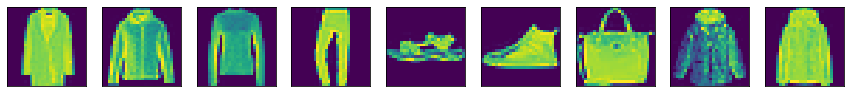

实际标签
['外套', '外套', '毛衣', '裤子', '凉鞋', '运动鞋', '包', '外套', '外套']
预测标签
['外套', '外套', '毛衣', '裤子', '运动鞋', '靴子', '包', '外套', '毛衣']


In [43]:
data, label = mnist_test[20:29]
show_images(data)
print('实际标签')
print(get_text_labels(label))

predicted_labels = net(data).argmax(axis = 1)
print('预测标签')
print(get_text_labels(predicted_labels.asnumpy()))